# Blood glucode prediction with 1h delay

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import random as python_random
import tensorflow as tf




2024-10-21 16:52:49.828862: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 16:52:49.838473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 16:52:49.849100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 16:52:49.852289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 16:52:49.860779: I tensorflow/core/platform/cpu_feature_guar

## Data loading

In [2]:
# Get the current working directory
cwd = os.getcwd()
print(cwd)

/home/jmaes/Documents/M2_BI/AIAO/Blood-Glucose-Prediction


In [3]:
# load the training data
train = pd.read_csv('data/train.csv')
test = pd.read_csv("data/test.csv")


/tmp/ipykernel_402595/468345928.py:2: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/train.csv')


In [4]:
# check import
print("Size of the data : ")
print(train.shape)
print("column nnames : ")
print(train.columns)
print("data types : ")
print(train.dtypes)
print(train.dtypes.count())

print(train.columns.values)


Size of the data : 
(177024, 508)
column nnames : 
Index(['id', 'p_num', 'time', 'bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40',
       'bg-5:35', 'bg-5:30', 'bg-5:25',
       ...
       'activity-0:40', 'activity-0:35', 'activity-0:30', 'activity-0:25',
       'activity-0:20', 'activity-0:15', 'activity-0:10', 'activity-0:05',
       'activity-0:00', 'bg+1:00'],
      dtype='object', length=508)
data types : 
id                object
p_num             object
time              object
bg-5:55          float64
bg-5:50          float64
                  ...   
activity-0:15     object
activity-0:10     object
activity-0:05     object
activity-0:00     object
bg+1:00          float64
Length: 508, dtype: object
508
['id' 'p_num' 'time' 'bg-5:55' 'bg-5:50' 'bg-5:45' 'bg-5:40' 'bg-5:35'
 'bg-5:30' 'bg-5:25' 'bg-5:20' 'bg-5:15' 'bg-5:10' 'bg-5:05' 'bg-5:00'
 'bg-4:55' 'bg-4:50' 'bg-4:45' 'bg-4:40' 'bg-4:35' 'bg-4:30' 'bg-4:25'
 'bg-4:20' 'bg-4:15' 'bg-4:10' 'bg-4:05' 'bg-4:00' 'bg-3:55' 'bg-3:50'


Convert the time data into a readable format

In [5]:
# # check time format
# print(train['time'].head())
# print("Time format : ")
# print(train["time"].dtypes)

# # convert time to datetime
# train['time'] = pd.to_datetime(train['time'])
# print(train['time'].head())
# print("Time format : ")
# print(train["time"].dtypes)


## Data descriptive statistics

In [6]:
# get the number of patients
print("Number of patients : ")
print(len(train['p_num'].unique()))
print("patient ids : ", train['p_num'].unique())

# number of measurements per patient
print("Number of measurements per patient : ")
print(train['p_num'].value_counts())


Number of patients : 
9
patient ids :  ['p01' 'p02' 'p03' 'p04' 'p05' 'p06' 'p10' 'p11' 'p12']
Number of measurements per patient : 
p_num
p03    26028
p02    25872
p10    25454
p12    25299
p04    24686
p11    24555
p01     8459
p06     8383
p05     8288
Name: count, dtype: int64


The number of measures per patient is not the same : data are not properly balanced.

In [7]:
# get the number of missing values
print("Number of missing values : ")
print(train.isnull().sum())
percentages = train.isnull().sum() / train.shape[0] * 100
print("Percentage of missing values : ")
print(percentages)


Number of missing values : 
id                    0
p_num                 0
time                  0
bg-5:55           27254
bg-5:50           18491
                  ...  
activity-0:15    174293
activity-0:10    174287
activity-0:05    174271
activity-0:00    174287
bg+1:00               0
Length: 508, dtype: int64
Percentage of missing values : 
id                0.000000
p_num             0.000000
time              0.000000
bg-5:55          15.395653
bg-5:50          10.445476
                   ...    
activity-0:15    98.457271
activity-0:10    98.453882
activity-0:05    98.444844
activity-0:00    98.453882
bg+1:00           0.000000
Length: 508, dtype: float64


In [8]:
# get the different times of measurements
print("Different times of measurements : ")
print(len(train['time'].unique()))
print(train['time'].unique())


Different times of measurements : 
288
['06:10:00' '06:25:00' '06:40:00' '06:55:00' '07:10:00' '07:25:00'
 '07:40:00' '07:55:00' '08:10:00' '08:25:00' '08:40:00' '08:55:00'
 '09:10:00' '09:25:00' '09:40:00' '09:55:00' '10:10:00' '10:25:00'
 '10:40:00' '10:55:00' '11:10:00' '11:25:00' '11:40:00' '11:55:00'
 '12:10:00' '12:25:00' '12:45:00' '13:00:00' '13:15:00' '13:30:00'
 '13:45:00' '14:00:00' '14:15:00' '14:30:00' '14:40:00' '15:00:00'
 '15:15:00' '15:30:00' '15:45:00' '16:00:00' '16:15:00' '16:30:00'
 '16:45:00' '17:00:00' '17:15:00' '17:30:00' '17:45:00' '18:00:00'
 '18:15:00' '18:30:00' '18:45:00' '19:00:00' '19:15:00' '19:30:00'
 '19:45:00' '20:00:00' '20:15:00' '20:30:00' '20:45:00' '21:00:00'
 '21:15:00' '21:30:00' '21:45:00' '22:00:00' '22:20:00' '22:35:00'
 '22:50:00' '23:05:00' '23:20:00' '23:35:00' '23:50:00' '00:05:00'
 '00:20:00' '00:35:00' '00:50:00' '01:05:00' '01:20:00' '01:35:00'
 '01:50:00' '02:05:00' '02:20:00' '02:35:00' '02:50:00' '03:05:00'
 '03:20:00' '03:35:00' 

The is continious measures for all of the patients : every five minutes during 24h. 
But, there is a lot of missing values. 

How to handle the NA?

- do data imputation? 
- remove the other time frame? 

In [9]:
train.describe()

,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,...,cals-0:40,cals-0:35,cals-0:30,cals-0:25,cals-0:20,cals-0:15,cals-0:10,cals-0:05,cals-0:00,bg+1:00
count,149770.000000,158533.000000,163364.000000,149766.000000,158254.000000,163770.000000,149763.000000,157973.000000,164174.000000,149771.000000,...,141694.000000,141706.000000,141713.000000,141722.000000,141732.000000,141741.000000,141751.000000,141761.000000,141767.000000,177024.000000
mean,8.211018,8.230449,8.253291,8.210988,8.229649,8.254083,8.211049,8.228888,8.254602,8.211000,...,9.364063,9.364096,9.362525,9.366591,9.368108,9.366998,9.370010,9.372536,9.368960,8.277045
std,2.852188,2.913438,2.945594,2.852090,2.911313,2.947651,2.852212,2.909304,2.949689,2.852315,...,8.012264,8.012681,8.017508,8.018465,8.018349,8.023788,8.021999,8.023280,8.023327,2.996398
min,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,...,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,2.200000
25%,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,...,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,6.100000
50%,7.600000,7.600000,7.700000,7.600000,7.600000,7.700000,7.600000,7.600000,7.700000,7.600000,...,6.180000,6.180000,6.170000,6.180000,6.180000,6.180000,6.180000,6.180000,6.180000,7.700000
75%,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,...,9.060000,9.060000,9.050000,9.060000,9.060000,9.060000,9.060000,9.070000,9.060000,9.900000
max,22.200000,25.100000,27.800000,22.200000,25.100000,27.800000,22.200000,25.100000,27.800000,22.200000,...,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,27.800000


# Handle missing values

remove sessions with empty insulin values

Impute the missing values

do encoding of exercice

remove heart rate values.


### Remove columns with no insulin values : 

In [10]:
print(f"train dataset initial: {train.shape}")

# Find the columns that contain the word 'insulin'
insulin_cols = [col for col in train.columns if 'insulin' in col]
print(insulin_cols)

# Filter out the rows where all insulin columns are all NaN
train.dropna(subset=insulin_cols, inplace=True, how="all")


print(f"train dataset filted: {train.shape}")


train dataset initial: (177024, 508)
['insulin-5:55', 'insulin-5:50', 'insulin-5:45', 'insulin-5:40', 'insulin-5:35', 'insulin-5:30', 'insulin-5:25', 'insulin-5:20', 'insulin-5:15', 'insulin-5:10', 'insulin-5:05', 'insulin-5:00', 'insulin-4:55', 'insulin-4:50', 'insulin-4:45', 'insulin-4:40', 'insulin-4:35', 'insulin-4:30', 'insulin-4:25', 'insulin-4:20', 'insulin-4:15', 'insulin-4:10', 'insulin-4:05', 'insulin-4:00', 'insulin-3:55', 'insulin-3:50', 'insulin-3:45', 'insulin-3:40', 'insulin-3:35', 'insulin-3:30', 'insulin-3:25', 'insulin-3:20', 'insulin-3:15', 'insulin-3:10', 'insulin-3:05', 'insulin-3:00', 'insulin-2:55', 'insulin-2:50', 'insulin-2:45', 'insulin-2:40', 'insulin-2:35', 'insulin-2:30', 'insulin-2:25', 'insulin-2:20', 'insulin-2:15', 'insulin-2:10', 'insulin-2:05', 'insulin-2:00', 'insulin-1:55', 'insulin-1:50', 'insulin-1:45', 'insulin-1:40', 'insulin-1:35', 'insulin-1:30', 'insulin-1:25', 'insulin-1:20', 'insulin-1:15', 'insulin-1:10', 'insulin-1:05', 'insulin-1:00', 'i

### Impute missing values for blood glucose :

In [11]:
def fill_na_with_linear_interpolation(df, prefixe):
    # Filter out all columns containing ‘bg’
    cols = [col for col in df.columns if col.startswith(prefixe)]
    
    # Linearly interpolate each row   
    df[cols] = df[cols].interpolate(method='linear', axis=1, limit_direction='both')
    
    return df

In [12]:
bg_cols = [col for col in train.columns if 'bg' in col]
print(bg_cols)

print(train[bg_cols].isnull().sum())

['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30', 'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10', 'bg-5:05', 'bg-5:00', 'bg-4:55', 'bg-4:50', 'bg-4:45', 'bg-4:40', 'bg-4:35', 'bg-4:30', 'bg-4:25', 'bg-4:20', 'bg-4:15', 'bg-4:10', 'bg-4:05', 'bg-4:00', 'bg-3:55', 'bg-3:50', 'bg-3:45', 'bg-3:40', 'bg-3:35', 'bg-3:30', 'bg-3:25', 'bg-3:20', 'bg-3:15', 'bg-3:10', 'bg-3:05', 'bg-3:00', 'bg-2:55', 'bg-2:50', 'bg-2:45', 'bg-2:40', 'bg-2:35', 'bg-2:30', 'bg-2:25', 'bg-2:20', 'bg-2:15', 'bg-2:10', 'bg-2:05', 'bg-2:00', 'bg-1:55', 'bg-1:50', 'bg-1:45', 'bg-1:40', 'bg-1:35', 'bg-1:30', 'bg-1:25', 'bg-1:20', 'bg-1:15', 'bg-1:10', 'bg-1:05', 'bg-1:00', 'bg-0:55', 'bg-0:50', 'bg-0:45', 'bg-0:40', 'bg-0:35', 'bg-0:30', 'bg-0:25', 'bg-0:20', 'bg-0:15', 'bg-0:10', 'bg-0:05', 'bg-0:00', 'bg+1:00']
bg-5:55    26985
bg-5:50    18225
bg-5:45    13396
bg-5:40    26996
bg-5:35    18510
           ...  
bg-0:15     3240
bg-0:10    25794
bg-0:05    24414
bg-0:00     2673
bg+1:00        0
Length: 7

In [13]:
train = fill_na_with_linear_interpolation(train, 'bg')
print(train[bg_cols].isnull().sum())

bg-5:55    0
bg-5:50    0
bg-5:45    0
bg-5:40    0
bg-5:35    0
          ..
bg-0:15    0
bg-0:10    0
bg-0:05    0
bg-0:00    0
bg+1:00    0
Length: 73, dtype: int64


### Impute the other variables

In [14]:
train.shape

(167659, 508)

In [15]:
# imputer insulin, carbs et steps avec des 0 (on considere que si rien n'a été déclaré, la valeur est a 0)
ins_cols = [col for col in train.columns if 'insulin' in col]
carbs_cols = [col for col in train.columns if 'carb' in col]
steps_cols = [col for col in train.columns if 'steps' in col]

to_impute0 = ins_cols + carbs_cols + steps_cols

# imputer = SimpleImputer(strategy='constant', fill_value = 0) 
imputer = SimpleImputer(strategy='constant', fill_value = -0.01)         
train[to_impute0] = imputer.fit_transform(train[to_impute0])
test[to_impute0] = imputer.transform(test[to_impute0])

# imputer cals colonnes avec des 1 (valeur moyenne par défaut de consommation de calorie au repos)
cals_cols = [col for col in train.columns if 'cals' in col]

# imputer = SimpleImputer(strategy='constant', fill_value = 1) 
imputer = SimpleImputer(strategy='constant', fill_value = -0.01)         
train[cals_cols] = imputer.fit_transform(train[cals_cols])
test[cals_cols] = imputer.transform(test[cals_cols])

print(train[to_impute0].isnull().sum())
print(train[cals_cols].isnull().sum())
print(train.shape)

insulin-5:55    0
insulin-5:50    0
insulin-5:45    0
insulin-5:40    0
insulin-5:35    0
               ..
steps-0:20      0
steps-0:15      0
steps-0:10      0
steps-0:05      0
steps-0:00      0
Length: 216, dtype: int64
cals-5:55    0
cals-5:50    0
cals-5:45    0
cals-5:40    0
cals-5:35    0
            ..
cals-0:20    0
cals-0:15    0
cals-0:10    0
cals-0:05    0
cals-0:00    0
Length: 72, dtype: int64
(167659, 508)


### Encode activity 

In [16]:
act_cols = [col for col in train.columns if 'activity' in col]
print(act_cols)

print(train[act_cols].describe())
print(train[act_cols].head())


['activity-5:55', 'activity-5:50', 'activity-5:45', 'activity-5:40', 'activity-5:35', 'activity-5:30', 'activity-5:25', 'activity-5:20', 'activity-5:15', 'activity-5:10', 'activity-5:05', 'activity-5:00', 'activity-4:55', 'activity-4:50', 'activity-4:45', 'activity-4:40', 'activity-4:35', 'activity-4:30', 'activity-4:25', 'activity-4:20', 'activity-4:15', 'activity-4:10', 'activity-4:05', 'activity-4:00', 'activity-3:55', 'activity-3:50', 'activity-3:45', 'activity-3:40', 'activity-3:35', 'activity-3:30', 'activity-3:25', 'activity-3:20', 'activity-3:15', 'activity-3:10', 'activity-3:05', 'activity-3:00', 'activity-2:55', 'activity-2:50', 'activity-2:45', 'activity-2:40', 'activity-2:35', 'activity-2:30', 'activity-2:25', 'activity-2:20', 'activity-2:15', 'activity-2:10', 'activity-2:05', 'activity-2:00', 'activity-1:55', 'activity-1:50', 'activity-1:45', 'activity-1:40', 'activity-1:35', 'activity-1:30', 'activity-1:25', 'activity-1:20', 'activity-1:15', 'activity-1:10', 'activity-1:0

In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

# List of activities
activities = ['Indoor climbing', 'Run', 'Strength training', 'Swim', 'Bike', 
              'Dancing', 'Stairclimber', 'Spinning', 'Walking', 'HIIT', 
              'Outdoor Bike', 'Walk', 'Aerobic Workout', 'Tennis', 'Workout', 
              'Hike', 'Zumba', 'Sport', 'Yoga', 'Swimming', 'Weights', 'Running']

# Create a dictionary mapping each activity to a unique number
activity_mapping = {activity: idx + 1 for idx, activity in enumerate(activities)}
activity_mapping[np.nan] = 0  # Map NaN to 0
activity_mapping['NaN'] = 0    # Handle string 'NaN' as well

# activity_mapping = {'Indoor climbing': 1,'Run': 2, 'Strength training': 3,'Swim': 4, 'Bike': 5, 'Dancing': 6,  'Stairclimber': 7, 'Spinning': 8,  'Walking': 9,  'HIIT': 10, 'Outdoor Bike': 11, 
#                     'Walk': 12,   'Aerobic Workout': 13,   'Tennis': 14,  'Workout': 15,    'Hike': 16,   'Zumba': 17, 'Sport': 18,  'Yoga': 19,  'Swimming': 20,  'Weights': 21,  'Running': 22,  nan: 0, 'NaN': 0}

# activity mapping, adjusted : I gather some sports in the same category, to simplify the model, like run = running
activity_mapping2 = {'Indoor climbing': 1, 
                    'Run': 2, 
                    'Strength training': 3, 
                    'Swim': 4, 
                    'Bike': 5, 
                    'Dancing': 6, 
                    'Stairclimber': 7, 
                    'Spinning': 8, 
                    'Walking': 9, 
                    'HIIT': 10, 
                    'Outdoor Bike': 5, 
                    'Walk': 9, 
                    'Aerobic Workout': 6, 
                    'Tennis': 11, 
                    'Workout': 3, 
                    'Hike': 12, 
                    'Zumba': 6, 
                    'Sport': 13, 
                    'Yoga': 14, 
                    'Swimming': 4, 
                    'Weights': 3, 
                    'Running': 2,
                    'NaN': 0} # no activity reported. 

# harsher regroupment of activity, depending on intensity : 0 : nothing/not reported, 1 : minor, 2 : medium, 3 : intense
activity_mapping3 = {'Indoor climbing': 2, 
                    'Run': 3, 
                    'Strength training': 2, 
                    'Swim': 3, 
                    'Bike': 3, 
                    'Dancing': 2, 
                    'Stairclimber': 2, 
                    'Spinning': 2, 
                    'Walking': 1, 
                    'HIIT': 3, 
                    'Outdoor Bike': 3, 
                    'Walk': 1, 
                    'Aerobic Workout': 1, 
                    'Tennis': 3, 
                    'Workout': 3, 
                    'Hike': 2, 
                    'Zumba': 2, 
                    'Sport': 2, 
                    'Yoga': 1, 
                    'Swimming': 3, 
                    'Weights': 3, 
                    'Running': 3,
                    'NaN': 0} # no activity reported.                     


print(activity_mapping3)

# Apply the mapping to the DataFrame
train[act_cols] = train[act_cols].applymap(lambda x: activity_mapping3.get(x, 0))

# Convert into factor
train[act_cols] = train[act_cols].astype('category')


{'Indoor climbing': 2, 'Run': 3, 'Strength training': 2, 'Swim': 3, 'Bike': 3, 'Dancing': 2, 'Stairclimber': 2, 'Spinning': 2, 'Walking': 1, 'HIIT': 3, 'Outdoor Bike': 3, 'Walk': 1, 'Aerobic Workout': 1, 'Tennis': 3, 'Workout': 3, 'Hike': 2, 'Zumba': 2, 'Sport': 2, 'Yoga': 1, 'Swimming': 3, 'Weights': 3, 'Running': 3, 'NaN': 0}


/tmp/ipykernel_402595/3114082254.py:73: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train[act_cols] = train[act_cols].applymap(lambda x: activity_mapping3.get(x, 0))


In [18]:
train[act_cols].describe()
print(train[act_cols].isnull().sum())

activity-5:55    0
activity-5:50    0
activity-5:45    0
activity-5:40    0
activity-5:35    0
                ..
activity-0:20    0
activity-0:15    0
activity-0:10    0
activity-0:05    0
activity-0:00    0
Length: 72, dtype: int64


### Drop heart rate columns because they have too many empty values

In [19]:
print(train.shape)
hr_cols = [col for col in train.columns if 'hr' in col]

train = train.drop(columns=hr_cols)
print(train.shape)


(167659, 508)
(167659, 436)


### Convert p_num to factor, but num

In [20]:
train["p_num"] = train["p_num"].astype('category')

In [21]:
# check
train["p_num"].describe()
train["p_num"].dtype

CategoricalDtype(categories=['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11',
                  'p12'],
, ordered=False, categories_dtype=object)

### Convert time to readable format

In [22]:
# date conversion
train.time = pd.to_datetime(train.time, format='%H:%M:%S')
test.time = pd.to_datetime(test.time, format='%H:%M:%S')

train['hour'] = train.time.dt.hour
test['hour'] = test.time.dt.hour

train['time_min'] = train['time'].dt.hour * 60 + train['time'].dt.minute
test['time_min'] = test['time'].dt.hour * 60 + test['time'].dt.minute

train['sin_time'] = np.sin(2 * np.pi * train['time_min'] / 1440)
train['cos_time'] = np.cos(2 * np.pi * train['time_min'] / 1440)

test['sin_time'] = np.sin(2 * np.pi * test['time_min'] / 1440)
test['cos_time'] = np.cos(2 * np.pi * test['time_min'] / 1440)

/tmp/ipykernel_402595/3567419781.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['hour'] = train.time.dt.hour
/tmp/ipykernel_402595/3567419781.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['hour'] = test.time.dt.hour
/tmp/ipykernel_402595/3567419781.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

### Final check de l'imputation et de la taille du dataset de train

In [23]:
print(train.shape)
print(train.isna().sum().sum())

(167659, 440)
0


In [52]:
print(train.columns.values)

['id' 'p_num' 'time' 'bg-5:55' 'bg-5:50' 'bg-5:45' 'bg-5:40' 'bg-5:35'
 'bg-5:30' 'bg-5:25' 'bg-5:20' 'bg-5:15' 'bg-5:10' 'bg-5:05' 'bg-5:00'
 'bg-4:55' 'bg-4:50' 'bg-4:45' 'bg-4:40' 'bg-4:35' 'bg-4:30' 'bg-4:25'
 'bg-4:20' 'bg-4:15' 'bg-4:10' 'bg-4:05' 'bg-4:00' 'bg-3:55' 'bg-3:50'
 'bg-3:45' 'bg-3:40' 'bg-3:35' 'bg-3:30' 'bg-3:25' 'bg-3:20' 'bg-3:15'
 'bg-3:10' 'bg-3:05' 'bg-3:00' 'bg-2:55' 'bg-2:50' 'bg-2:45' 'bg-2:40'
 'bg-2:35' 'bg-2:30' 'bg-2:25' 'bg-2:20' 'bg-2:15' 'bg-2:10' 'bg-2:05'
 'bg-2:00' 'bg-1:55' 'bg-1:50' 'bg-1:45' 'bg-1:40' 'bg-1:35' 'bg-1:30'
 'bg-1:25' 'bg-1:20' 'bg-1:15' 'bg-1:10' 'bg-1:05' 'bg-1:00' 'bg-0:55'
 'bg-0:50' 'bg-0:45' 'bg-0:40' 'bg-0:35' 'bg-0:30' 'bg-0:25' 'bg-0:20'
 'bg-0:15' 'bg-0:10' 'bg-0:05' 'bg-0:00' 'insulin-5:55' 'insulin-5:50'
 'insulin-5:45' 'insulin-5:40' 'insulin-5:35' 'insulin-5:30'
 'insulin-5:25' 'insulin-5:20' 'insulin-5:15' 'insulin-5:10'
 'insulin-5:05' 'insulin-5:00' 'insulin-4:55' 'insulin-4:50'
 'insulin-4:45' 'insulin-4:40' 'insu

### Correlation entre les variables

In [56]:
corr = train.drop(columns=['bg+1:00', 'id', 'p_num', 'time', 'hour', "time_min" ]).corr()
print(corr)

                bg-5:55   bg-5:50   bg-5:45   bg-5:40   bg-5:35   bg-5:30  \
bg-5:55        1.000000  0.994357  0.981336  0.962672  0.939768  0.914370   
bg-5:50        0.994357  1.000000  0.994028  0.979957  0.959910  0.936243   
bg-5:45        0.981336  0.994028  1.000000  0.993611  0.978742  0.958324   
bg-5:40        0.962672  0.979957  0.993611  1.000000  0.993606  0.978947   
bg-5:35        0.939768  0.959910  0.978742  0.993606  1.000000  0.993613   
...                 ...       ...       ...       ...       ...       ...   
activity-0:10 -0.020506 -0.020080 -0.019820 -0.019567 -0.019215 -0.018908   
activity-0:05 -0.020007 -0.019576 -0.019105 -0.018713 -0.018312 -0.017957   
activity-0:00 -0.019693 -0.019359 -0.018918 -0.018407 -0.017942 -0.017622   
sin_time       0.110409  0.108448  0.106516  0.104798  0.102898  0.101014   
cos_time       0.078538  0.080513  0.082506  0.084685  0.086711  0.088712   

                bg-5:25   bg-5:20   bg-5:15   bg-5:10  ...  activity-0:35  

# Random forest

In [24]:
# Separation des descripteurs (features) et de la cible (target)
X = train.drop(columns=['bg+1:00', 'id', 'p_num', 'time', 'hour', "time_min" ])  # Supprime les colonnes non pertinentes, on garde time pour l'instant car le moment de la journée pourrait etre important pour la valeur du bg
y = train['bg+1:00']

# Séparation en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle de forêt aléatoire
rf = RandomForestRegressor(n_estimators=100, random_state=42)

## Entraînement du modèle

In [25]:
def reset_seeds(seed = 42):
   np.random.seed(seed) 
   python_random.seed(seed)
   tf.random.set_seed(seed)

In [26]:
reset_seeds()
history = rf.fit(X_train, y_train)

In [45]:
# model summary
rf.summary

AttributeError: 'RandomForestRegressor' object has no attribute 'summary'

## Evaluation

In [27]:
score = rf.score(X_test, y_test)
print(f'Score R^2: {score}')

Score R^2: 0.6870591289019672


In [50]:
import keras.backend as K
from keras.losses import mean_squared_error

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print(y_train_pred[0:50])

# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))

# rmsd_train = root_mean_squared_error(y_train, y_train_pred)
# rmse_test = root_mean_squared_error(y_test, y_test_pred)

rmse_train
rmse_test



[ 6.268  6.436 13.602  6.886  8.692  4.341  7.425 12.496  6.274  5.019
 13.161  7.928  9.236 12.053  5.726  6.276  6.771  7.135  8.499  6.559
  8.203  5.539  7.139  5.872  6.298  5.663 12.322  9.787  5.09   5.789
  8.549  6.63  10.    12.714  5.726  5.797  9.307 11.15   9.125  6.571
 14.994 11.873  6.441  7.01  11.042  5.164  9.218  5.333  5.852  6.761]
tf.Tensor(0.3853885372221849, shape=(), dtype=float64)


NameError: name 'rmse_train' is not defined

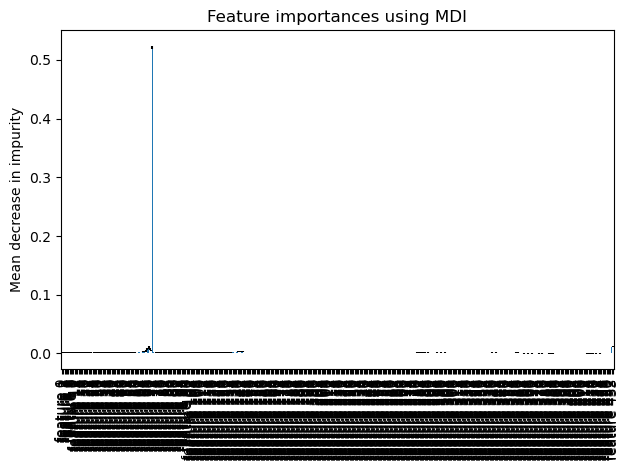

In [43]:
# check feature importance

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(rf.feature_importances_, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [ ]:
train.dtypes